<a href="https://colab.research.google.com/github/waelrash1/predictive_analytics_DT302/blob/main/NLP_Logistic_Regression%2Bthreshold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <a name="0">Logistic Regression - Natural Language Processing</a>

## Logistic Regression Model and Threshold Calibration

In this notebook, we go over the Logistic Regression method to predict the __isPositive__ field of our final dataset, while also having a look at how probability threshold calibration can help improve classifier's performance.

1. <a href="#1">Reading the dataset</a>
2. <a href="#2">Exploratory data analysis</a>
3. <a href="#3">Stop word removal and stemming</a>
4. <a href="#4">Train - Validation Split</a>
5. <a href="#5">Data processing with Pipeline and ColumnTransform</a>
6. <a href="#6">Fit the classifier</a>
Find more details on the __LogisticRegression__ here: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
7. <a href="#7">Test the classifier</a>
8. <a href="#8">Ideas for improvement: Probability threshold calibration (optional)</a>

Overall dataset schema:
* __reviewText:__ Text of the review
* __summary:__ Summary of the review
* __verified:__ Whether the purchase was verified (True or False)
* __time:__ UNIX timestamp for the review
* __log_votes:__ Logarithm-adjusted votes log(1+votes)
* __isPositive:__ Whether the review is positive or negative (1 or 0)


## 1. <a name="1">Reading the dataset</a>
(<a href="#0">Go to top</a>)

We will use the __pandas__ library to read our datasets.

In [1]:
import pandas as pd
url='https://raw.githubusercontent.com/aws-samples/aws-machine-learning-university-accelerated-nlp/master/data/examples/AMAZON-REVIEW-DATA-CLASSIFICATION.csv'

df = pd.read_csv(url)

Let's look at the first five rows in the datasets.

In [2]:
df.head()

,reviewText,summary,verified,time,log_votes,isPositive
0,"PURCHASED FOR YOUNGSTER WHO\nINHERITED MY ""TOO...",IDEAL FOR BEGINNER!,True,1361836800,0.000000,1.0
1,unable to open or use,Two Stars,True,1452643200,0.000000,0.0
2,Waste of money!!! It wouldn't load to my system.,Dont buy it!,True,1433289600,0.000000,0.0
3,I attempted to install this OS on two differen...,I attempted to install this OS on two differen...,True,1518912000,0.000000,0.0
4,I've spent 14 fruitless hours over the past tw...,Do NOT Download.,True,1441929600,1.098612,0.0


## 2. <a name="2">Exploratory data analysis</a>
(<a href="#0">Go to top</a>)

Let's look at the target distribution for our datasets.

In [3]:
df["isPositive"].value_counts()

1.0    43692
0.0    26308
Name: isPositive, dtype: int64

Checking the number of missing values:    

In [4]:
print(df.isna().sum())

reviewText    11
summary       14
verified       0
time           0
log_votes      0
isPositive     0
dtype: int64


We have missing values in our text fields.

## 3. <a name="3">Text Processing: Stop words removal and stemming</a>
(<a href="#0">Go to top</a>)

We will apply the text processing methods discussed in the class.

In [5]:
# Install the library and functions
# Importing the Natural Language Toolkit (NLTK) library
# NLTK is a leading platform for building Python programs to work with human language data.
import nltk

# Downloading the Punkt Tokenizer Models
# Punkt is used for dividing text into a list of sentence tokens.
# This is particularly useful for splitting a text into sentences.
nltk.download('punkt')

# Downloading the list of stopwords
# Stopwords are common words that generally don't carry much meaning and are often omitted in text processing.
# Examples include 'and', 'the', 'is', etc. This is useful for text analysis and preprocessing.
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

We will create the stop word removal and text cleaning processes below. NLTK library provides a list of common stop words. We will use the list, but remove some of the words from that list (because those words are actually useful to understand the sentiment in the sentence).

In [6]:
import nltk, re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize

# Let's get a list of stop words from the NLTK library
stop = stopwords.words('english')

# These words are important for our problem. We don't want to remove them.
excluding = ['against', 'not', 'don', "don't",'ain', 'aren', "aren't", 'couldn', "couldn't",
             'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't",
             'haven', "haven't", 'isn', "isn't", 'mightn', "mightn't", 'mustn', "mustn't",
             'needn', "needn't",'shouldn', "shouldn't", 'wasn', "wasn't", 'weren',
             "weren't", 'won', "won't", 'wouldn', "wouldn't"]

# New stop word list
stop_words = [word for word in stop if word not in excluding]

snow = SnowballStemmer('english')

def process_text(texts):
    final_text_list=[]
    for sent in texts:

        # Check if the sentence is a missing value
        if isinstance(sent, str) == False:
            sent = ""

        filtered_sentence=[]

        sent = sent.lower() # Lowercase
        sent = sent.strip() # Remove leading/trailing whitespace
        sent = re.sub('\s+', ' ', sent) # Remove extra space and tabs
        sent = re.compile('<.*?>').sub('', sent) # Remove HTML tags/markups:

        for w in word_tokenize(sent):
            # We are applying some custom filtering here, feel free to try different things
            # Check if it is not numeric and its length>2 and not in stop words
            if(not w.isnumeric()) and (len(w)>2) and (w not in stop_words):
                # Stem and add to filtered list
                filtered_sentence.append(snow.stem(w))
        final_string = " ".join(filtered_sentence) #final string of cleaned words

        final_text_list.append(final_string)

    return final_text_list

## 4. <a name="4">Train - Validation Split</a>
(<a href="#0">Go to top</a>)

Let's split our dataset into training (90%) and validation (10%).

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(df[["reviewText", "summary", "time", "log_votes"]],
                                                  df["isPositive"],
                                                  test_size=0.10,
                                                  shuffle=True,
                                                  random_state=324
                                                 )

In [8]:
print("Processing the reviewText fields")
X_train["reviewText"] = process_text(X_train["reviewText"].tolist())
X_val["reviewText"] = process_text(X_val["reviewText"].tolist())

print("Processing the summary fields")
X_train["summary"] = process_text(X_train["summary"].tolist())
X_val["summary"] = process_text(X_val["summary"].tolist())

Processing the reviewText fields
Processing the summary fields


Our process_text() method in section 3 uses empty string for missing values.

## 5. <a name="5">Data processing with Pipeline and ColumnTransform</a>
(<a href="#0">Go to top</a>)

In the previous examples, we have seen how to use pipeline to prepare a data field for our machine learning model. This time, we will focus on multiple fields: numeric and text fields. Find more details on __LogisticRegression__ here:
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

   * For the numerical features pipeline, the __numerical_processor__ below, we use a MinMaxScaler (don't have to scale features when using Decision Trees, but it's a good idea to see how to use more data transforms). If different processing is desired for different numerical features, different pipelines should be built - just like shown below for the two text features.
   * For the text features pipeline, the __text_processor__ below, we use CountVectorizer() for the text fields.
   
The selective preparations of the dataset features are then put together into a collective ColumnTransformer, to be finally used in a Pipeline along with an estimator. This ensures that the transforms are performed automatically on the raw data when fitting the model and when making predictions, such as when evaluating the model on a validation dataset via cross-validation or making predictions on a test dataset in the future.

In [9]:
# Selecting numerical features for the model
# 'time' and 'log_votes' are numerical variables chosen as features for the model.
# These features are likely quantitative data that can be directly used in the model without needing preprocessing like text data.

numerical_features = ['time', 'log_votes']

# Selecting text features for the model
# 'summary' and 'reviewText' are text variables chosen as features.
# These are likely to be processed differently than numerical data, typically requiring tokenization, vectorization, or other forms of text preprocessing.

text_features = ['summary', 'reviewText']

# Combining numerical and text features into a single list
# This unified list 'model_features' will be used as the input features for the model.
# It is important to process these features according to their types (numerical or text) during feature engineering.

model_features = numerical_features + text_features

# Defining the target variable for the model
# 'isPositive' is set as the target variable, which the model will predict.
# This is likely a binary variable (e.g., positive vs. negative) used in a classification task.
model_target = 'isPositive'

In [13]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression

### COLUMN_TRANSFORMER ###
##########################

# Preprocess the numerical features
# Preprocessing Numerical Features
# This pipeline is for preprocessing numerical features.
# It uses MinMaxScaler to scale numerical features to a range between 0 and 1.
# Scaling is important for models that are sensitive to the magnitude of features.
numerical_processor = Pipeline([
    ('num_scaler', MinMaxScaler())
])

# Preprocessing the First Text Feature
# This pipeline is for the first text feature, using CountVectorizer.
# CountVectorizer converts text data into a matrix of token counts, here with a binary outcome (word presence or absence).
# 'max_features=50' limits the maximum number of features to the top 50 most frequent words.
text_processor_0 = Pipeline([
    ('text_vect_0', CountVectorizer(binary=True, max_features=50))
])

# Preprocessing the Second Text Feature with a Larger Vocabulary
# Similar to the first text processor, but with a larger vocabulary (150 max features).
# This may be because the second text feature requires a broader range of words for adequate representation.
text_precessor_1 = Pipeline([
    ('text_vect_1', CountVectorizer(binary=True, max_features=150))
])

# Combining All Data Preprocessors
# ColumnTransformer allows different preprocessing steps for different columns of data.
# It specifies which processor to apply to which columns.
# Here, numerical data is scaled, and two text features are vectorized with different settings.
data_preprocessor = ColumnTransformer([
    ('numerical_pre', numerical_processor, numerical_features),
    ('text_pre_0', text_processor_0, text_features[0]),
    ('text_pre_1', text_precessor_1, text_features[1])
])

### PIPELINE ###
################


# Assembling the Full Pipeline
# This pipeline integrates data preprocessing steps and a machine learning model (Logistic Regression).
# Logistic Regression is used for binary classification (here likely predicting 'isPositive').
# Hyperparameters like 'penalty' and 'C' are set for the logistic regression model.
# The pipeline allows for streamlined processing and prediction.
pipeline = Pipeline([
    ('data_preprocessing', data_preprocessor),
    ('logistic_regression', LogisticRegression(penalty = 'l2', class_weight=class_w,
                              C = 0.1))
])

# Visualizing the Pipeline
# Visual representation of the pipeline is enabled for clarity, especially useful for more complex pipelines.
from sklearn import set_config
set_config(display='diagram')
pipeline


Pipeline(steps=[('data_preprocessing',
                 ColumnTransformer(transformers=[('numerical_pre',
                                                  Pipeline(steps=[('num_scaler',
                                                                   MinMaxScaler())]),
                                                  ['time', 'log_votes']),
                                                 ('text_pre_0',
                                                  Pipeline(steps=[('text_vect_0',
                                                                   CountVectorizer(binary=True,
                                                                                   max_features=50))]),
                                                  'summary'),
                                                 ('text_pre_1',
                                                  Pipeline(steps=[('text_vect_1',
                                                                   CountVectorizer(binary=True,
                                                                                   max_features=150))]),
                                                  'reviewText')])),
                ('logistic_regression',
                 LogisticRegression(C=0.1,
                                    class_weight=[0.8575805978420314,
                                                  0.1424194021579685]))])

In [36]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Assuming your classes are labeled as 0 and 1
class_labels = np.unique(y_train)  # y_train should be your target variable array from the training data

# Computing class weights
# 'balanced' mode uses the values of y to automatically adjust weights inversely proportional to class frequencies
class_weights = compute_class_weight('balanced', classes=class_labels, y=y_train)

# Creating a dictionary to pass to the model
class_weights_dict = {class_labels[i]: class_weights[i] for i in range(len(class_labels))}


# Assembling the Full Pipeline
# This pipeline integrates data preprocessing steps and a machine learning model (Logistic Regression).
# Logistic Regression is used for binary classification (here likely predicting 'isPositive').
# Hyperparameters like 'penalty' and 'C' are set for the logistic regression model.
# The pipeline allows for streamlined processing and prediction.
pipeline = Pipeline([
    ('data_preprocessing', data_preprocessor),
    ('logistic_regression', LogisticRegression(penalty = 'l2', class_weight=class_weights_dict,
                              C = 0.1, max_iter=1000, solver='saga'))
])

# Visualizing the Pipeline
# Visual representation of the pipeline is enabled for clarity, especially useful for more complex pipelines.
from sklearn import set_config
set_config(display='diagram')
pipeline


Pipeline(steps=[('data_preprocessing',
                 ColumnTransformer(transformers=[('numerical_pre',
                                                  Pipeline(steps=[('num_scaler',
                                                                   MinMaxScaler())]),
                                                  ['time', 'log_votes']),
                                                 ('text_pre_0',
                                                  Pipeline(steps=[('text_vect_0',
                                                                   CountVectorizer(binary=True,
                                                                                   max_features=50))]),
                                                  'summary'),
                                                 ('text_pre_1',
                                                  Pipeline(steps=[('text_vect_1',
                                                                   CountVectorizer(binary=True,
                                                                                   max_features=150))]),
                                                  'reviewText')])),
                ('logistic_regression',
                 LogisticRegression(C=0.1,
                                    class_weight={0.0: 1.32894570307556,
                                                  1.0: 0.801587907473853},
                                    max_iter=1000, solver='saga'))])

## 6. <a name="6">Fit the classifier</a>
(<a href="#0">Go to top</a>)

We train our model by using __.fit()__ on our training dataset.


In [37]:
# Fit the Pipeline to training data
pipeline.fit(X_train, y_train.values)

Pipeline(steps=[('data_preprocessing',
                 ColumnTransformer(transformers=[('numerical_pre',
                                                  Pipeline(steps=[('num_scaler',
                                                                   MinMaxScaler())]),
                                                  ['time', 'log_votes']),
                                                 ('text_pre_0',
                                                  Pipeline(steps=[('text_vect_0',
                                                                   CountVectorizer(binary=True,
                                                                                   max_features=50))]),
                                                  'summary'),
                                                 ('text_pre_1',
                                                  Pipeline(steps=[('text_vect_1',
                                                                   CountVectorizer(binary=True,
                                                                                   max_features=150))]),
                                                  'reviewText')])),
                ('logistic_regression',
                 LogisticRegression(C=0.1,
                                    class_weight={0.0: 1.32894570307556,
                                                  1.0: 0.801587907473853},
                                    max_iter=1000, solver='saga'))])

## 7. <a name="7">Test the classifier</a>
(<a href="#0">Go to top</a>)

Let's evaluate the performance of the trained classifier. We use __.predict()__ this time.

In [38]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Making Predictions on the Validation Dataset
# This line uses the previously defined and fitted pipeline to make predictions on the validation dataset.
# The 'predict' method applies all preprocessing steps to the validation data and then uses the trained model for prediction.
val_predictions = pipeline.predict(X_val)

# Printing the Confusion Matrix
# The confusion matrix is a table used to evaluate the performance of the classification model.
# It shows the actual vs. predicted values, helping to understand the cases of true positives, true negatives, false positives, and false negatives.
print(confusion_matrix(y_val.values, val_predictions))

# Printing the Classification Report
# The classification report provides key metrics about the performance of the classifier.
# This includes precision, recall, f1-score for each class, and a support count showing the number of true instances in each class.
print(classification_report(y_val.values, val_predictions))

# Calculating and Printing the Accuracy
# Accuracy is the ratio of correctly predicted observations to the total observations.
# High accuracy means the model performs well on the validation data.
# It's a quick way to see how well the model is performing, especially for balanced datasets.
print("Accuracy (validation):", accuracy_score(y_val.values, val_predictions))


[[2225  380]
 [ 710 3685]]
              precision    recall  f1-score   support

         0.0       0.76      0.85      0.80      2605
         1.0       0.91      0.84      0.87      4395

    accuracy                           0.84      7000
   macro avg       0.83      0.85      0.84      7000
weighted avg       0.85      0.84      0.85      7000

Accuracy (validation): 0.8442857142857143


## 8. <a name="8">Ideas for improvement: Probability threshold calibration (optional)</a>
(<a href="#0">Go to top</a>)

Besides tuning __LogisticRegression__ hyperparameter values, one other path to improve a classifier's performance is to dig deeper into how the classifier actually assigns class membership.

**Binary predictions versus probability predictions.** We often use __classifier.predict()__ to examine classifier binary predictions, while in fact the outputs of most classifiers are real-valued, not binary. For most classifiers in sklearn, the method __classifier.predict_proba()__ returns class probabilities as a two-dimensional numpy array of shape (n_samples, n_classes) where the classes are lexicographically ordered.

For our example, let's look at the first 5 predictions we made, in binary format and in real-valued probability format:

In [21]:
pipeline.predict(X_val)[0:5]

array([1., 1., 1., 1., 0.])

In [22]:
pipeline.predict_proba(X_val)[0:5]

array([[0.0567855 , 0.9432145 ],
       [0.04919826, 0.95080174],
       [0.11983214, 0.88016786],
       [0.01514955, 0.98485045],
       [0.8965617 , 0.1034383 ]])

**How are the predicted probabilities used to decide class membership?** On each row of predict_proba output, the probabilities values sum to 1. There are two columns, one for each response class: column 0 - predicted probability that each observation is a member of class 0; column 1 - predicted probability that each observation is a member of class 1. From the predicted probabilities, choose the class with the highest probability.

The key here is that a **threshold of 0.5** is used by default (for binary problems) to convert predicted probabilities into class predictions: class 0, if predicted probability is less than 0.5; class 1, if predicted probability is greater than 0.5.

**Can we improve classifier performance by changing the classification threshold?** Let's **adjust** the classification threshold to influence the performance of the classifier.


### 8.1 Threshold calibration to improve model accuracy

We calculate the accuracy using different values for the classification threshold, and pick the threshold that resulted in the highest accuracy.

Highest Accuracy on Validation: 0.8477142857142858 , Threshold for the highest Accuracy: 0.42


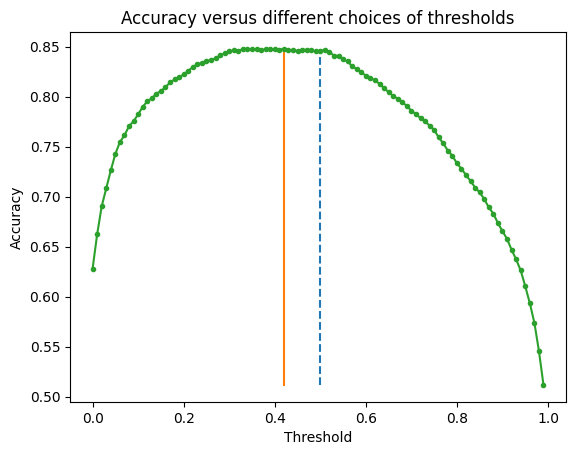

In [33]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Calculate the accuracy using different values for the classification threshold,
# and pick the threshold that resulted in the highest accuracy.
highest_accuracy = 0
threshold_highest_accuracy = 0

thresholds = np.arange(0,1,0.01)
scores = []
for t in thresholds:
    # set threshold to 't' instead of 0.5
    y_val_other = (pipeline.predict_proba(X_val)[:,1] >= t).astype(float)
    score = accuracy_score(y_val, y_val_other)
    scores.append(score)
    if(score > highest_accuracy):
        highest_accuracy = score
        threshold_highest_accuracy = t
print("Highest Accuracy on Validation:", highest_accuracy, \
      ", Threshold for the highest Accuracy:", threshold_highest_accuracy)

# Let's plot the accuracy versus different choices of thresholds
plt.plot([0.5, 0.5], [np.min(scores), np.max(scores)], linestyle='--')
plt.plot([threshold_highest_accuracy , threshold_highest_accuracy ], [np.min(scores), np.max(scores)], linestyle='-')

plt.plot(thresholds, scores, marker='.')
plt.title('Accuracy versus different choices of thresholds')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.show()

### 8.2 Threshold calibration to improve model F1 score

Similarly, various choices of classification thresholds would affect the Precision and Recall metrics. Precision and Recall are usually trade offs of each other, so when you can improve both at the same time, your model's overall performance is undeniably improved. To choose a threshold that balances Precision and Recall, we can plot the Precision-Recall curve and pick the point with the highest F1 score.

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Calculate the precision and recall using different values for the classification threshold
val_predictions_probs = pipeline.predict_proba(X_val)
precisions, recalls, thresholds = precision_recall_curve(y_val, val_predictions_probs[:, 1])

Using the Precision and Recall values from the curve above, we calculate the F1 scores using:

$$\text{F1_score} = \frac{2*(\text{Precision} * \text{Recall})}{(\text{Precision} + \text{Recall})}$$

and pick the threshold that gives the highest F1 score.

Highest F1 score on Validation: 0.8834688346883468 , Threshold for the highest F1 score: 0.3051458933128468


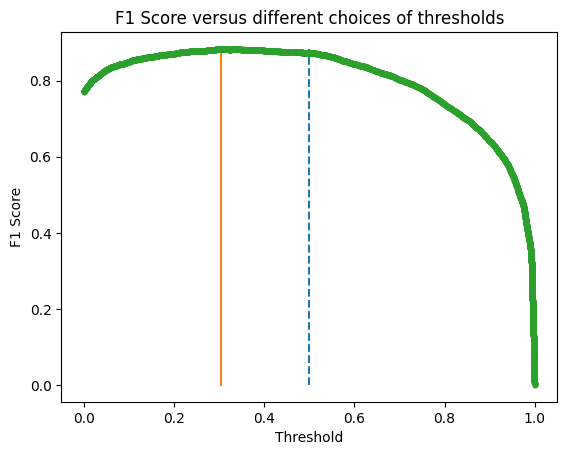

In [30]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Calculate the F1 score using different values for the classification threshold,
# and pick the threshold that resulted in the highest F1 score.
highest_f1 = 0
threshold_highest_f1 = 0

f1_scores = []
for id, threhold in enumerate(thresholds):
    f1_score = 2*precisions[id]*recalls[id]/(precisions[id]+recalls[id])
    f1_scores.append(f1_score)
    if(f1_score > highest_f1):
        highest_f1 = f1_score
        threshold_highest_f1 = threhold
print("Highest F1 score on Validation:", highest_f1, \
      ", Threshold for the highest F1 score:", threshold_highest_f1)

# Let's plot the F1 score versus different choices of thresholds
plt.plot([0.5, 0.5], [np.min(f1_scores), np.max(f1_scores)], linestyle='--')

plt.plot([threshold_highest_f1 , threshold_highest_f1 ], [np.min(f1_scores), np.max(f1_scores)], linestyle='-')

plt.plot(thresholds, f1_scores, marker='.')
plt.title('F1 Score versus different choices of thresholds')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.show()

# Parameter Tuning

## Grid Search

In [39]:
from sklearn.model_selection import GridSearchCV

# Define a parameter grid to search for best parameters for everything in the pipeline
# This grid will specify which parameters to tune and their respective ranges of values to test.
# For example, here we are tuning 'logistic_regression__C' (regularization strength) and
# 'text_vect_0__max_features' (number of maximum features for the first text vectorizer).
param_grid = {
    'data_preprocessing__text_pre_0__text_vect_0__max_features': [50, 100, 150],  # Adjusting for first text vectorizer
    'data_preprocessing__text_pre_1__text_vect_1__max_features': [100, 150, 200], # Adjusting for second text vectorizer
    'logistic_regression__C': [0.1, 1, 10]  # Adjusting regularization strength
}

# Rest of your GridSearchCV setup and fitting remains the same


# Create a GridSearchCV object to perform a grid search with the pipeline
# The GridSearchCV will train the model for each combination of parameters in the param_grid,
# and evaluate using cross-validation to find the best parameters.
grid_search = GridSearchCV(pipeline, param_grid, cv=5)

# Fitting the GridSearchCV to the training data
# This step will train and evaluate the model for each combination of parameters
# and identify the combination that produces the best results.
grid_search.fit(X_train, y_train.values)

# After fitting, the best parameters can be extracted and used.
print("Best Parameters:", grid_search.best_params_)

# The pipeline can now be used with these optimal parameters for prediction or further analysis.


Best Parameters: {'data_preprocessing__text_pre_0__text_vect_0__max_features': 150, 'data_preprocessing__text_pre_1__text_vect_1__max_features': 200, 'logistic_regression__C': 1}


Best Parameters: {'data_preprocessing__text_pre_0__text_vect_0__max_features': 150, 'data_preprocessing__text_pre_1__text_vect_1__max_features': 200, 'logistic_regression__C': 1}


In [53]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression

### COLUMN_TRANSFORMER ###
##########################

# Preprocess the numerical features
# Preprocessing Numerical Features
# This pipeline is for preprocessing numerical features.
# It uses MinMaxScaler to scale numerical features to a range between 0 and 1.
# Scaling is important for models that are sensitive to the magnitude of features.
numerical_processor = Pipeline([
    ('num_scaler', MinMaxScaler())
])

# Preprocessing the First Text Feature
# This pipeline is for the first text feature, using CountVectorizer.
# CountVectorizer converts text data into a matrix of token counts, here with a binary outcome (word presence or absence).
# 'max_features=50' limits the maximum number of features to the top 50 most frequent words.
text_processor_0 = Pipeline([
    ('text_vect_0', TfidfVectorizer(max_features=150))
])
TfidfVectorizer
# Preprocessing the Second Text Feature with a Larger Vocabulary
# Similar to the first text processor, but with a larger vocabulary (150 max features).
# This may be because the second text feature requires a broader range of words for adequate representation.
text_precessor_1 = Pipeline([
    ('text_vect_1', TfidfVectorizer( max_features=200))
])

# Combining All Data Preprocessors
# ColumnTransformer allows different preprocessing steps for different columns of data.
# It specifies which processor to apply to which columns.
# Here, numerical data is scaled, and two text features are vectorized with different settings.
data_preprocessor = ColumnTransformer([
    ('numerical_pre', numerical_processor, numerical_features),
    ('text_pre_0', text_processor_0, text_features[0]),
    ('text_pre_1', text_precessor_1, text_features[1])
])

### PIPELINE ###
################


# Assembling the Full Pipeline
# This pipeline integrates data preprocessing steps and a machine learning model (Logistic Regression).
# Logistic Regression is used for binary classification (here likely predicting 'isPositive').
# Hyperparameters like 'penalty' and 'C' are set for the logistic regression model.
# The pipeline allows for streamlined processing and prediction.
pipeline = Pipeline([
    ('data_preprocessing', data_preprocessor),
    ('logistic_regression', LogisticRegression(penalty = 'l2',solver='saga',max_iter=1000,
                              C = 1))
])

# Visualizing the Pipeline
# Visual representation of the pipeline is enabled for clarity, especially useful for more complex pipelines.
from sklearn import set_config
set_config(display='diagram')
pipeline



Pipeline(steps=[('data_preprocessing',
                 ColumnTransformer(transformers=[('numerical_pre',
                                                  Pipeline(steps=[('num_scaler',
                                                                   MinMaxScaler())]),
                                                  ['time', 'log_votes']),
                                                 ('text_pre_0',
                                                  Pipeline(steps=[('text_vect_0',
                                                                   TfidfVectorizer(max_features=150))]),
                                                  'summary'),
                                                 ('text_pre_1',
                                                  Pipeline(steps=[('text_vect_1',
                                                                   TfidfVectorizer(max_features=200))]),
                                                  'reviewText')])),
                ('logistic_regression',
                 LogisticRegression(C=1, max_iter=1000, solver='saga'))])

In [54]:
# Fit the Pipeline to training data
pipeline.fit(X_train, y_train.values)

Pipeline(steps=[('data_preprocessing',
                 ColumnTransformer(transformers=[('numerical_pre',
                                                  Pipeline(steps=[('num_scaler',
                                                                   MinMaxScaler())]),
                                                  ['time', 'log_votes']),
                                                 ('text_pre_0',
                                                  Pipeline(steps=[('text_vect_0',
                                                                   TfidfVectorizer(max_features=150))]),
                                                  'summary'),
                                                 ('text_pre_1',
                                                  Pipeline(steps=[('text_vect_1',
                                                                   TfidfVectorizer(max_features=200))]),
                                                  'reviewText')])),
                ('logistic_regression',
                 LogisticRegression(C=1, max_iter=1000, solver='saga'))])

In [55]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Making Predictions on the Validation Dataset
# This line uses the previously defined and fitted pipeline to make predictions on the validation dataset.
# The 'predict' method applies all preprocessing steps to the validation data and then uses the trained model for prediction.
val_predictions = pipeline.predict(X_val)

# Printing the Confusion Matrix
# The confusion matrix is a table used to evaluate the performance of the classification model.
# It shows the actual vs. predicted values, helping to understand the cases of true positives, true negatives, false positives, and false negatives.
print(confusion_matrix(y_val.values, val_predictions))

# Printing the Classification Report
# The classification report provides key metrics about the performance of the classifier.
# This includes precision, recall, f1-score for each class, and a support count showing the number of true instances in each class.
print(classification_report(y_val.values, val_predictions))

# Calculating and Printing the Accuracy
# Accuracy is the ratio of correctly predicted observations to the total observations.
# High accuracy means the model performs well on the validation data.
# It's a quick way to see how well the model is performing, especially for balanced datasets.
print("Accuracy (validation):", accuracy_score(y_val.values, val_predictions))


[[2097  508]
 [ 425 3970]]
              precision    recall  f1-score   support

         0.0       0.83      0.80      0.82      2605
         1.0       0.89      0.90      0.89      4395

    accuracy                           0.87      7000
   macro avg       0.86      0.85      0.86      7000
weighted avg       0.87      0.87      0.87      7000

Accuracy (validation): 0.8667142857142857


In [57]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Calculate the precision and recall using different values for the classification threshold
val_predictions_probs = pipeline.predict_proba(X_val)
precisions, recalls, thresholds = precision_recall_curve(y_val, val_predictions_probs[:, 1])

Highest F1 score on Validation: 0.8976010661928032 , Threshold for the highest F1 score: 0.46245610185468083


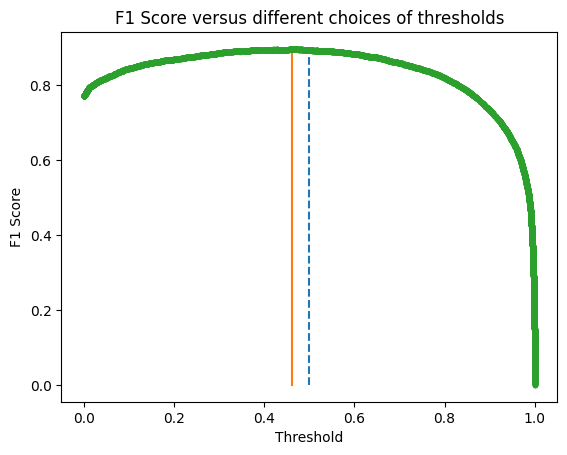

In [58]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Calculate the F1 score using different values for the classification threshold,
# and pick the threshold that resulted in the highest F1 score.
highest_f1 = 0
threshold_highest_f1 = 0

f1_scores = []
for id, threhold in enumerate(thresholds):
    f1_score = 2*precisions[id]*recalls[id]/(precisions[id]+recalls[id])
    f1_scores.append(f1_score)
    if(f1_score > highest_f1):
        highest_f1 = f1_score
        threshold_highest_f1 = threhold
print("Highest F1 score on Validation:", highest_f1, \
      ", Threshold for the highest F1 score:", threshold_highest_f1)

# Let's plot the F1 score versus different choices of thresholds
plt.plot([0.5, 0.5], [np.min(f1_scores), np.max(f1_scores)], linestyle='--')

plt.plot([threshold_highest_f1 , threshold_highest_f1 ], [np.min(f1_scores), np.max(f1_scores)], linestyle='-')

plt.plot(thresholds, f1_scores, marker='.')
plt.title('F1 Score versus different choices of thresholds')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.show()